In [2]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch import nn, Tensor, TupleType
from torch.nn import Transformer
from torch.nn import LSTM

from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
def __d(K, n):
  return (math.factorial(K - 1 + n)) / (math.factorial(K - 1) * math.factorial(n))

def PolynomialActivation(x):
  # x = x + 0.4
  N = 11
  K = 6
  zeta = 0.5 #y
  value = 0.5 #x
  dK = 0
  Sigmaz = 0
  for n in range(0, N - K):
    dK = dK + __d(K, n) * math.pow((1 - x), n)
  for n in range(0, N - K):
    Sigmaz = Sigmaz + __d(K, n) * math.pow((1 - zeta), n)
  CNK = (value * (zeta ** (-K)) - Sigmaz) / ((1 - zeta) ** (N - K))
  
  return np.where(x < 0., 0., 
                  np.where(x > 1., 1., 
                           math.pow(x, K) * (dK + (CNK * (math.pow((1 - x), (N - K)))))))

def SOC_fuzzy(SOC_tf, SOC_tf_prev, idx):
    # print(-1*PolynomialActivation(abs(SOC_tf - SOC_tf_prev)) + 1)
    # print(" ")
    # print(abs(SOC_tf - SOC_tf_prev))
    w1 = (-1*PolynomialActivation(abs(SOC_tf - SOC_tf_prev)) + 1)
    w2 = 1-w1

    return w1*(SOC_tf) + w2*(SOC_tf_prev)

In [4]:
class CustomDataset2(Dataset):
    def __init__(self, file_path, x_size):
        df = pd.read_csv(file_path)
        #print(df.isnull().sum())

        self.I = df.iloc[x_size:, 6:7].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
        self.y = df.iloc[x_size:, 13:14].values
        
        self.length = len(df) - x_size

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        # label = torch.FloatTensor(self.y[index])

        return feature

    def __len__(self):
        return self.length

In [5]:
dataset_d2 = CustomDataset2("FUDS_80.csv", 2586)

In [6]:
def fx(x_esti, idx):
    # return A * x_esti + (dataset_d2.I[idx]*(1/44.72) / (1.648484097)) 
    return x_esti + (dataset_d2.I[idx]*100*(1.009217) / (1.600182 *3600/0.8)) #US -> 1.648484097 / DST -> 1.594214 / FUDS->1.600182  / BJDST->1.653517646
# US -> 1.007828486 / DST -> 1.00612 /  FUDS -> 1.009217  /  BJDST -> 1.001287

In [7]:
dataset_d2.y.shape

(11095, 1)

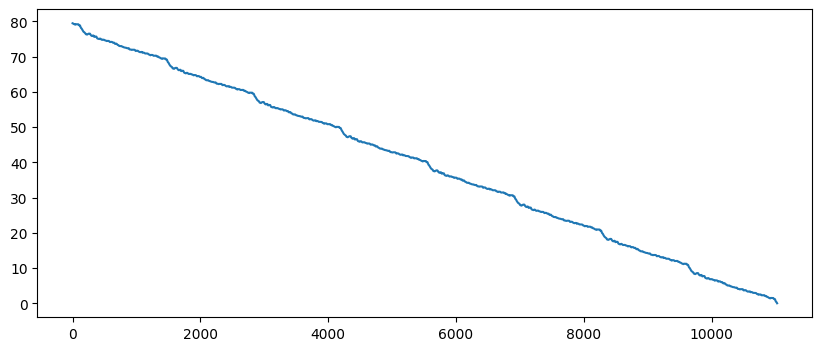

In [8]:
n_samples = 11095

arr = np.zeros(n_samples)

for i in range(n_samples):
    if i<1:
        z_meas_prev = 80
    else:
        z_meas_prev = fx(z_meas_prev, i)

    arr[i] = z_meas_prev


plt.figure(figsize=(10,4))

# plt.plot(arr[69:], label='cc')
plt.plot(dataset_d2.y[69:], label='cc')

# plt.legend(loc='upper right')
# plt.title('fuzzy')
# plt.xlabel('Time Steps')
from sklearn.metrics import mean_absolute_error, mean_squared_error

# print("mae : ", mean_absolute_error(arr[69:10000], dataset_d2.y[69:10000]))
# print("mse : ", mean_squared_error(arr[69:10000], dataset_d2.y[69:10000]))
# print("rmse : ", np.sqrt(mean_squared_error(arr[69:10000], dataset_d2.y[69:10000])))